In [1]:
from colorama import Fore
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# print in colors
def print_fore(obj, color=Fore.BLUE):
    print(color + str(obj))

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
def show_image(image_array, title=""):
    image = image_array.reshape(3, 32,32).transpose(1,2,0)
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap=None)
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Unpickle the metadata

In [5]:
metadata_file = "cifar-10-batches-py\\batches.meta"
metadata = unpickle(metadata_file)

#### List of label descriptions

In [6]:
labels_name = [x.decode('UTF-8') for x in metadata.get(b'label_names')]
print_fore(str(labels_name))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### Unpickle the batches - prepare data and labels

In [7]:
def prepare_data(files):
    batch_dir = "cifar-10-batches-py\\"
    #files = files # ["data_batch_1", "data_batch_2"]
    key_data = "data".encode('UTF-8')
    key_labels = "labels".encode('UTF-8')
    
    all_data = np.empty([0, 3072], dtype=np.uint8)
    all_labels = []

    for d in files:
        dict_cifar = unpickle(batch_dir+d) # unpickle file to dict
        data = dict_cifar.get(key_data) #data_from_dict(dict_cifar) # get data from dict
        labels = list(dict_cifar.get(key_labels))
        all_data = np.concatenate((all_data, data), axis=0)
        all_labels.append(labels) # np.concatenate((all_labels, labels), axis=0)

    return all_data, np.array(all_labels).flatten()

### Prepare train and test sets

#### Put data in a numpy array
Each row stores a 32x32 color image.<br>
The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue.<br>
The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

In [8]:
train_data_files = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"]
X_train, y_train = prepare_data(files = train_data_files)
print_fore(X_train.shape)
print_fore(y_train.shape)

(50000, 3072)
(50000,)


In [9]:
test_data_files = ["test_batch"]
X_test, y_test = prepare_data(files = test_data_files)
print_fore(X_test.shape)
print_fore(y_test.shape)

(10000, 3072)
(10000,)


#### Show an image with label in title

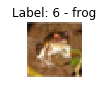

In [10]:
image_index = 0
test_image = X_train[image_index]   
show_image(image_array=test_image, title="Label: {} - {}".format(str(y_train[image_index]), str(labels_name[y_train[image_index]])))

# Nearest Neighbor Classifier
Basic approach to image classification problem<br>
The nearest neighbor classifier will take a test image, compare it to every single one of the training images, and predict the label of the closest training image

#### Manhattan distance (L1) & Euclidean distance (L2)
Step by step example on how to calculate distances between arrays using Manhattan distance. <br>

Matrix <i>three_pics</i> represents 3 pictures in a form of 3x3 matrix (each picture is represented in an array). There is an array <i>pic</i> which we will find closest array to in the three_pics matrix. 

In [11]:
# np.random.seed(1) # uncomment for nonrandomized integers
three_pics = np.random.randint(10, size=(3,3))
print_fore("Three pics:\n" + str(three_pics))

pic = np.random.randint(10, size=(1,3))
print_fore("\nTest pic:\n" + str(pic))

dist_abs = np.abs(three_pics - pic)
print_fore("\nSubstraction and absolute:\n" + str(dist_abs))

dist = np.sum(dist_abs, axis=1)
print_fore("\nDistance between three pics and pic:\n" + str(dist))

min_dist_index = np.argmin(dist)
print_fore("\nIndex of minimum distance array:\n" + str(min_dist_index))

closest_pic = three_pics[min_dist_index]
print_fore("\nClosest pic from array:\n" + str(closest_pic))

Three pics:
[[3 5 8]
 [3 0 1]
 [0 3 9]]

Test pic:
[[9 8 2]]

Substraction and absolute:
[[6 3 6]
 [6 8 1]
 [9 5 7]]

Distance between three pics and pic:
[15 15 21]

Index of minimum distance array:
0

Closest pic from array:
[3 5 8]


## Nearest neighbor
There is no training, all the job is done in the prediction phase - not most practical when you would like to predict in near real time.

In [12]:
class Nearest_Neighbor():
    def __init__(self, distance="L1"):
        self.distance = distance
    
    def train(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_pred):
        y_pred = []
        for i_pred, x_pred in enumerate(X_pred):
            if self.distance == "L1":
                dist = np.sum(np.abs(self.X - x_pred), axis=1) # calculate distances to every picture in train
            elif self.distance == "L2":
                dist = np.sqrt(np.sum(np.square(self.X - x_pred)))
            min_dist_index = np.argmin(dist) # find index of minimum distance
            y_label = self.y[min_dist_index] # find value in labels corresponding the min distance index
            y_pred.append(y_label) 
        return np.array(y_pred)

### Train the model

In [13]:
nn = Nearest_Neighbor(distance="L1")
nn.train(X=X_train, y=y_train)

### Predict labels on test data
#### Will take some time!
It is comparing every test example (10.000) with every train example (60.000)

In [14]:
#y_pred = nn.predict(X_pred=X_test)

#### Rather predict on a smaller set
If running on smaller dataset, skip to k-Nearest Neighbor Classifier

In [15]:
n_test_unit = 500
y_pred = nn.predict(X_pred=X_test[:n_test_unit])
print_fore("Testing on {} images".format(n_test_unit))
print_fore('Accuracy: %f' % ( np.mean(y_pred == y_test[:n_test_unit]) ))

Testing on 500 images
Accuracy: 0.248000


In [16]:
list_row = []
list_acc = []
min_range = 10
max_range = 110
for i in range(min_range, max_range, 10):
    n_test_unit = i
    y_pred = nn.predict(X_pred=X_test[:n_test_unit])
    acc = np.mean(y_pred == y_test[:n_test_unit])
    list_acc.append(acc)
    list_row.append(i)
    print_fore("{} - {}".format(i, acc))

10 - 0.2
20 - 0.2
30 - 0.2
40 - 0.15
50 - 0.14
60 - 0.16666666666666666
70 - 0.17142857142857143
80 - 0.2
90 - 0.17777777777777778
100 - 0.18


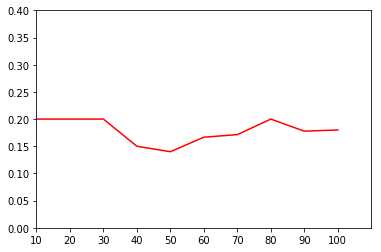

In [17]:
plt.plot(list_row, list_acc, "r-")
axes = plt.gca()
axes.set_xlim([min_range, max_range])
axes.set_ylim([0,0.4])
xi = [i for i in range(0, len(list_row))]
plt.xticks(list_row, list_row)
plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

### Calculate accuracy score on whole train set

In [18]:
#print_fore('Accuracy: %f' % ( np.mean(y_pred == y_test) ))

### Calculate accuracy score using accuracy_score

In [19]:
from sklearn.metrics import accuracy_score

#accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
#print_fore("Accuracy: {}".format(accuracy))

## k-Nearest Neighbor Classifier
Create an instance of KNN and train (fit) the data

In [20]:
from sklearn.neighbors import KNeighborsClassifier
k = 50
clf = KNeighborsClassifier(n_neighbors=k, weights="uniform")
clf.fit(X=X_train, y=y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')

#### Predict

In [21]:
n_test_unit = 500
y_pred = clf.predict(X=X_test[:n_test_unit])

In [22]:
print_fore('Accuracy: %f' % ( np.mean(y_pred == y_test[:n_test_unit]) ))

Accuracy: 0.314000


Notes on accuracy for various number of neighbors (k):<br>
7 - 0.314000<br>
15 - 0.318000<br>
50 - 0.314000